<div align="right" style="text-align: right"><i>Peter Norvig<br>August 2021</i></div>

# RaceTrack

From 538's [The Riddler](https://fivethirtyeight.com/features/can-you-zoom-around-the-race-track/) on 6 August 2021 (slightly edited):

> The game of [RaceTrack](https://link.springer.com/chapter/10.1007/978-3-642-13122-6_26) was published by recreational mathematician [Martin Gardner](http://www.martin-gardner.org/) in [1973](https://www.scientificamerican.com/article/mathematical-games-1973-01/). There have been some neat [digital versions](https://harmmade.com/vectorracer/#) since then, and it’s high time we had a race here: the Riddler-opolis 500!
>
> You begin at the blue point on the starting line below the circle (diagram shown below) with a velocity vector of zero, and your goal is to circumnavigate the track in a counterclockwise loop. You’ll be moving in straight line segments from point to point on the grid, without ever crashing into the outer wall or the central circle.  (Moving tangent to the circle is allowed, as is being on a grid point along a wall.)
>
> For each move you have a choice of nine possible destinations, corresponding to the 3x3 grid that surrounds the point formed by adding your current velocity vector to your current position. That is, you can maintain your current velocity, or you can alter your velocity (and hence your destination) by accelerating one grid point in any direction (horizontally, vertically or diagonally). For example, if your first move was up and to the right, then your nine possible second moves are shown below, although two of them will cause you to crash into the central circle and one of them is standing still.
>
> How quickly can you navigate the track? 
>
> ![](https://fivethirtyeight.com/wp-content/uploads/2021/08/Screen-Shot-2021-08-04-at-10.44.11-PM.png?w=200)


# Defining Points, Vectors, and Paths

We will need to represent 2-D points on a grid, as well as 2-D vectors for velocity and acceleration. I will use the following choices:
- `Point(x, y)`: a point in the 2-D plane, implemented as a complex number.
- `Vector(x, y)`: a 2-D vector, also implemented as a complex number.
- `Path`: the car's history of position points as it moves, implemented as a list of Points.
- `X(point)`, `Y(point)`: the x- and y-coordinates of a point, respectively.
- `zero`, `up`, `right`: vectors that stay still, move one unit up, and move one to the right, respectively.
- `accelerations`: the nine possible acceleration vectors (to change the car's velocity).

In [1]:
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Set

Point  = complex
Vector = complex
Path   = List[Point]

def X(point) -> float: "x-coordinate"; return point.real
def Y(point) -> float: "y-coordinate"; return point.imag

zero, up, right = Vector(0, 0), Vector(0, 1), Vector(1, 0)

accelerations = [up-right,  up,   up+right, 
                 -right,    zero, right, 
                 -up-right, -up,  -up+right]

*Note:* I debated whether the elements of a `Path` should be just points, or (point, velocity) pairs, because that's what uniquely identifies the state of a car. I decided it was simpler to just use points. Given a path, the velocity can be easily computed:

In [2]:
def velocity(path) -> Vector:
    """Velocity of the car when it is at the end of the path."""
    return zero if len(path) == 1 else path[-1] - path[-2]  

# Defining the Track

I want to solve RaceTrack games both on the particular track posed by The Riddler, and on differently-shaped race tracks. I'll define the class `Track` to be a set of points, but annotated with 
attribute/value pairs (which can vary for different tracks).

In [3]:
class Track(Set):
    """The set of legal points on the track, with any attributes."""
    def __init__(self, items, **kwds):
        self.update(items)
        self.__dict__.update(kwds)

For The Riddler's track, the track points are all those points on a 15x15 square except the ones that fall inside the circle's radius.  The track also has three attributes:
- `track.start`: the single starting point.
- `track.finish`: the two endpoints of the finish line.
- `track.radius`: the radius of the central circle (whose center, without loss of generality, is the origin).

In [4]:
side   = range(-7, 8)
points = {Point(x, y) for x in side for y in side if abs(Point(x, y)) >= 3}
track  = Track(points, start=Point(0, -5), finish=[Point(0, -3), Point(0, -7)], radius=3)

# Visualization

It will be really helpful to be able to visualize paths on the track:

In [5]:
def plot(paths=(), track=track):
    """Plot the track and any paths, along with the start and finish line."""
    fig, ax = plt.subplots()
    plt.xticks([]); plt.yticks([])
    ax.set_aspect('equal')
    ax.add_artist(plt.Circle((0, 0), track.radius, alpha=1/3, color='k', ec='w'))
    ax.plot(*XY(track), 'k,' )                # grid points
    ax.plot(*XY([track.start]), 'ks', ms=10)  # start point
    ax.plot(*XY(track.finish), 'k-')          # finish line
    for path in paths:                        # paths
        ax.plot(*XY(path), 'o-')  
    plt.title(f'{len(paths)} paths of {set(len(path) - 1 for path in paths)} moves')
    
def XY(points) -> Tuple[List[float], List[float]]: 
    """A tuple of: (the x-coordinates of points, the y-coordinates of points)."""
    # This converts points into the format that plt.plot expects 
    return [X(p) for p in points], [Y(p) for p in points]

Below is my recreation of The Riddler's diagram of the first two moves. Here and throughout I'll use the convention:
- `p` is a point indicating a move.
- `v` is the velocity of the move.
- `p1` is where the next point would be if the velocity remains constant.
- `p2` is where the next point actually is with acceleration applied to change the velocity.

In this example, `p` is up and right from the start, and from there there are 9 possible values for `p2`.

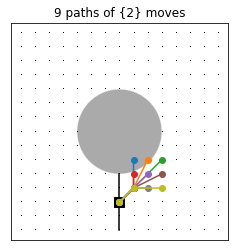

In [6]:
v   = up + right
p   = track.start + v
p1  = p + v
p2s = [p1 + a for a in accelerations]

plot([[track.start, p, p2] for p2 in p2s])

# Circumnavigating the Track

What exactly does it mean to  mean to "circumnavigate the track in a counterclockwise loop"? I'll define a circumnavigation (and thus, a *solution*) as a path goes from the plane's fourth [**quadrant**](https://mathworld.wolfram.com/Quadrant.html)  to the first, second, third, and back to the fourth. (Points with an x-coordinate of exactly 0 are considered to be in the first or fourth quadrant.) 

<center><div><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Cartesian-coordinate-system-with-quadrant.svg/242px-Cartesian-coordinate-system-with-quadrant.svg.png" width=120></div></center>


In [7]:
def is_solution(path, goals=(4, 1, 2, 3, 4)) -> bool:
    """Does the path go through all the goal quadrants in the prescribed order?"""
    i = 0 # Index of next goal to be achieved
    for p in path:
        if quadrant(p) == goals[i]:
            i += 1 # Start looking for the next goal
            if i == len(goals):
                return True
    return False

def quadrant(p: Point) -> int: 
    """What quadrant of the 2-D plane is this point in?"""
    if X(p) >= 0:
        return 1 if Y(p) > 0 else 4
    else: 
        return 2 if Y(p) > 0 else 3

To generalize this to other race tracks, you could change the definition of `quadrant` (there could be more than 4 "quadrants," and they could have any shape), and change the `goals` in `is_solution`.

# Legal Moves

As stated earlier, I want to solve the specific Riddler track, and also make the code general enough that it can handle other tracks. I'll do that by splitting up responsibility for determining legal moves:
- `all_moves(path, track)` is general; it returns track points that can be reached with any acceleration.
- `riddler_track_moves(path, track)` is specific; it limits moves in the following ways:
  - It won't make moves that stay in one place (they are legal, but wasteful on this track).
  - It won't pass from the fourth quadrant backwards over the finish line into the third (legal, but wasteful).
  - It won't let a move's line segment intersect the central circle (even if the start and end points of the move are on valid track points outside of the circle).


In [8]:
def all_moves(path, track=track) -> Set[Point]:
    """Moves with any allowable acceleration that end up on the track."""
    p1 = path[-1] + velocity(path)
    return {(p1 + a) for a in accelerations} & track
                
def riddler_track_moves(path, track=track) -> Set[Point]:
    """Reasonable moves on The Riddler's track."""
    p = path[-1]
    return {p2 for p2 in all_moves(path, track)
            if p2 != p
            and not (quadrant(p) == 4 and quadrant(p2) == 3) # Don't go backwards
            and not intersects_circle(p, p2, track)}

The math for solving for the intersection of a line segment and a circle  [looks complicated](https://stackoverflow.com/questions/6091728/line-segment-circle-intersection), so instead I just define N+1 points along the line from point *p* to point *p2* and check if any of those points is within the radius of the circle. I chose N to be big enough that I believe this approach won't miss any intersection points on our small track.

In [9]:
def intersects_circle(p: Point, p2: Point, track=track) -> bool:
    """Does any point w on the line from p to p2 fall within radius of center?"""
    return any(abs(w) < track.radius for w in waypoints(p, p2))

def waypoints(p, p2, N=20) -> List[Point]:
    """All the points that are i/N of the way from p to p2"""
    return [p + (i / N) * (p2 - p)
            for i in range(N + 1)]

# A Frontier of Possible Paths

Now I want to expand paths by adding legal moves to the end until I find solution(s). I could keep *all* my paths in a `list`, but there will be an exponential number of them: O(9<sup><i>n<i/></sup>) paths of length *n*. 

I am not looking for all solutions, just one fastest solution (or possibly a small sampling of them). So I am willing to discard some partial paths if I can prove that they can never lead to a faster solution than another partial path.
    
The key idea is that there may be many partial paths that arrive at the some endpoint with the same velocity in the same number of moves. I only need to keep one of them, because they can all be continued in exactly the same ways.

I will define a data structure that I call a `Frontier`, which is a dict of `{(endpoint, velocity): path}`. By the nature of dicts, this keeps only one path for each `(endpoint, velocity)` pair. 
    
Here's how I expand a frontier, adding one more move in all possible ways, and discarding duplicates:

In [10]:
Frontier = Dict[Tuple[Point, Vector], Path]

def expand(frontier, legal_moves=riddler_track_moves, track=track) -> Frontier:
    """The {(endpoint, velocity): path} frontier extended one move in all legal ways."""
    return {(p, velocity([path[-1], p])): path + [p] 
            for path in frontier.values() 
            for p in legal_moves(path, track)}

*Note:* Before I added the limitation that moves can't pass backwards from the fourth quadrant to the third, it was possible that two different paths would arrive at the same point in the third quadrant with the same velocity. If  the path that was discarded had circumnavigated and the path that was kept  had not, that was **a bug** that  discarded some valid solutions.

# Searching for the Fastest Solutions

Now all I have to do to solve the problem is repeatedly expand the frontier until one or more solutions are found. The first solutions found are guaranteed to be the fastest (i.e., they are the paths with the fewest possible moves), because we are expanding paths one move at a time. In the end, `search` returns a list of all the solutions in the frontier, but there may be many other paths that are not returned, because the frontier only keeps one path for each `(endpoint, velocity)` pair, and there are only so many ways to cross the finish line. 

In [11]:
def search(track=track, path=None, legal_moves=riddler_track_moves) -> List[Path]:
    """Find the shortest possible solution paths."""
    if path is None: path = [track.start]
    frontier = {(path[-1], velocity(path)): path}
    solutions = []
    while not solutions:
        frontier  = expand(frontier, legal_moves, track)
        solutions = [path for path in frontier.values() if is_solution(path)]
    return solutions

# Solutions!

We are ready to solve the problem:

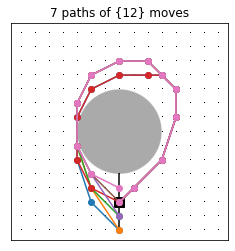

In [12]:
solutions = search(track)

plot(solutions)

We see that the fastest solution is 12 moves, and there are at least 7 ways to get there (with perhaps others discarded).

# Submitting your Answer

I'll need a bit of "tricky work" to put my answers into the form requested by The Riddler:

> Finally, submitting your answer can be tricky work. Please be sure to submit both your total time, as well as your sequence of moves. Each move should be assigned a digit from 1 through 9, corresponding to the nine possible destinations of the move:
>
>     1 2 3
>     4 5 6
>     7 8 9

I already started the tricky work by defining the nine `accelerations` to be in this order. I finish the tricky work by defining two functions to translate back and forth between my `Path` and The Riddler's `Digits`: 

In [13]:
Digits = List[int] # each int is 1-9

def digits_from_path(path) -> Digits:
    """The digits that the path represents."""
    return [1 + accelerations.index(velocity(path[:i + 1]) - velocity(path[:i])) 
            for i in range(1, len(path))]

def path_from_digits(digits, start=track.start) -> Path:
    """The path that the digits represent."""
    v = zero # Starting velocity
    path = [start]
    for d in digits:
        v += accelerations[d - 1]
        path.append(v + path[-1])
    return path

In [14]:
[digits_from_path(path) for path in solutions]

[[3, 3, 1, 7, 7, 8, 4, 8, 9, 9, 6, 3],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 6, 6],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 6, 3],
 [3, 3, 1, 7, 7, 8, 4, 8, 9, 9, 3, 3],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 9],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 6],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 3]]

# Alternative Solutions

I have identified six different opening sequences of moves that each lead to solutions with the fastest possible time of 12 moves. I don't understand exactly why in each case there exactly 7 solution paths are reported; I suppose it is just because the finish line is crowded and there are only so many ways to get there.

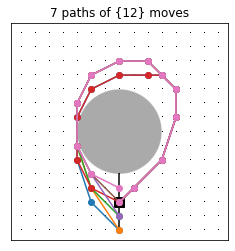

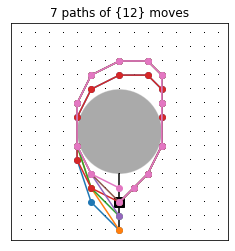

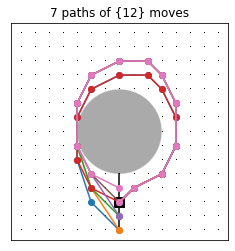

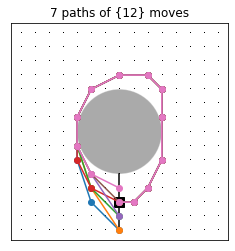

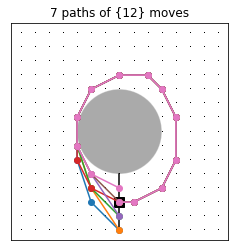

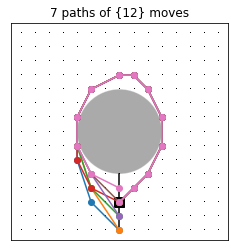

In [15]:
openings = [3, 3], [3, 5], [3, 6], [6, 2], [6, 3], [3, 5, 2, 4, 4]

for digits in openings:
    plot(search(track, path=path_from_digits(digits)))

# Visualizations and Tests

To gain more confidence in the code, here are some additional visualizations and unit tests:

In [16]:
def test_intersects(expected: bool, segments: List[Path]):
    """Test if [p, q] segments get the expected result from `intersects_circle`."""
    plot(segments)
    for p, q in segments:
        assert intersects_circle(p, q) is expected

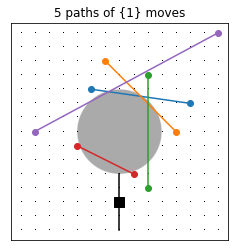

In [17]:
test_intersects(True, [ # Line segments that intersect the circle
    [Point(-2, 3), Point(5, 2)], 
    [Point(-1, 5), Point(4, 0)], 
    [Point(2, 4),  Point(2, -4)],
    [Point(-3, -1),Point(1, -3)],
    [Point(-6, 0), Point(7, 7)]])

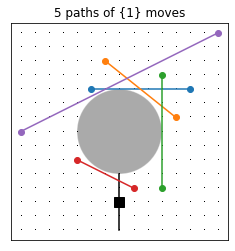

In [18]:
test_intersects(False, [ # Line segments that do not intersect the circle
    [Point(-2, 3), Point(5, 3)], 
    [Point(-1, 5), Point(4, 1)], 
    [Point(3, 4),  Point(3, -4)],
    [Point(-3, -2),Point(1, -4)],
    [Point(-7, 0), Point(7, 7)]])

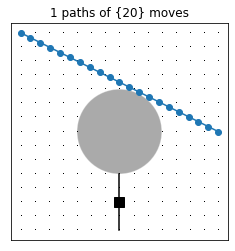

In [19]:
# Waypoints on a line segment
p, q = Point(-7, 7), Point(7, 0)
plot([waypoints(p, q)])
assert not intersects_circle(p, q)

Here's a visualization for `expand(frontier)` showing the first six expansions.
Note that the growth in number of paths is much slower then O(9<sup><i>n</i></sup>). After 6 moves there are only 1,107 paths, which is 500 times fewer than 9<sup>6</sup> = 531,441.

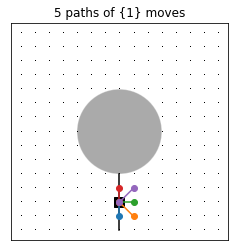

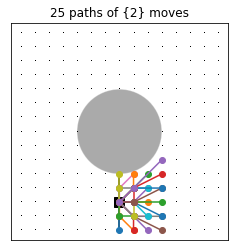

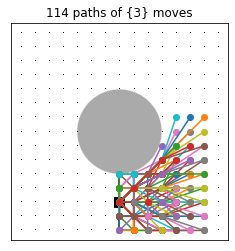

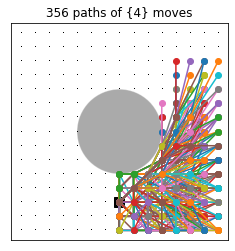

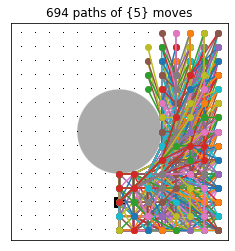

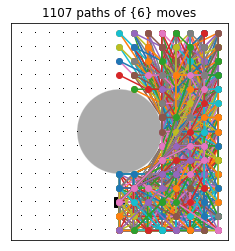

In [20]:
frontier = {(track.start, zero): [track.start]}

for i in range(6):
    frontier = expand(frontier)
    plot(frontier.values())

# A Different Track

Although the code here is not ready to handle large, arbitrary-shaped tracks, it can handle some minor track variations. Here I define `track2` to be a track with a larger central circle, and a circular ring of valid points rather than a full rectangular grid:

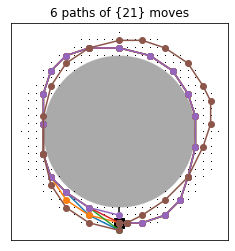

In [21]:
radius2 = 10
side2  = range(-14, 15)
start2 = Point(0, -radius2 - 2)
track2 = Track({Point(x, y) for x in side2 for y in side2 
                if radius2 <= abs(Point(x, y)) <= radius2 + 3}, 
               radius=radius2, start=start2, 
               finish=[Point(0, -radius2), Point(0, -radius2 - 3)])

solutions2 = search(track2)
    
plot(solutions2, track=track2)

In [22]:
[digits_from_path(path) for path in solutions2]

[[6, 6, 3, 1, 1, 2, 4, 7, 4, 7, 7, 8, 9, 9, 9, 9, 5, 3, 3, 9, 3],
 [6, 6, 3, 1, 1, 2, 4, 7, 4, 7, 7, 8, 9, 9, 9, 9, 5, 3, 6, 3, 3],
 [6, 6, 3, 1, 1, 2, 4, 7, 4, 7, 7, 8, 9, 9, 9, 9, 5, 3, 3, 6, 9],
 [6, 6, 3, 1, 1, 2, 4, 7, 4, 7, 7, 8, 9, 9, 9, 9, 5, 3, 3, 6, 6],
 [6, 6, 3, 1, 1, 2, 4, 7, 4, 7, 7, 8, 9, 9, 9, 9, 5, 3, 3, 6, 3],
 [6, 3, 3, 2, 1, 7, 4, 7, 1, 7, 8, 8, 7, 9, 9, 9, 9, 3, 3, 3, 3]]

# Additional tests

In [23]:
start = track.start
path1 = [start, Point(1, -4)] # First move

assert start == Point(0, -5) == 0-5j
assert X(start) == 0 and Y(start) == -5 
assert velocity([start]) == 0
assert velocity(path1) == Vector(1, 1)
assert XY(path1) == ([0, 1], [-5, -4])

assert quadrant(Point(1, -4)) == 4 == quadrant(start)
assert quadrant(Point(1, 2))  == 1
assert quadrant(Point(-5, 4)) == 2
assert quadrant(Point(-1, -1))== 3

assert waypoints(0, 100, 10) == [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
assert waypoints(zero, Point(10, 20), 10) == [
    0j,1+2j,2+4j,3+6j,4+8j,5+10j,6+12j,7+14j,8+16j,9+18j,10+20j]

# There are 9 moves from the start point
assert all_moves([start]) == {
    -1-4j, -1-5j,  -1-6j, 
     0-4j,  0-5j,   0-6j, 
     1-4j,  1-5j,   1-6j}

# But 3 moves are backwards and 1 stays in the same place; those are disallowed
assert riddler_track_moves([start]) == {0-6j, 1-6j, 1-5j, 0-4j, 1-4j}
assert expand({(start, zero): [start]}) == {
 (0-6j, 0-1j): [0-5j, 0-6j],
 (1-6j, 1-1j): [0-5j, 1-6j],
 (1-5j, 1+0j): [0-5j, 1-5j],
 (0-4j, 0+1j): [0-5j, 0-4j],
 (1-4j, 1+1j): [0-5j, 1-4j]}

for path in solutions:
    digits = digits_from_path(path)
    assert path   == path_from_digits(digits_from_path(path))   # Inverses
    assert digits == digits_from_path(path_from_digits(digits)) # Inverses

'tests pass'

'tests pass'